# **Introduction** 

The competition dataset contains text from works of fiction written by spooky authors of the public domain: **Edgar Allan Poe**, **HP Lovecraft** and **Mary Shelley**. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. The objective is to accurately identify the author of the sentences in the test set.


---




# **Data Field**

**id** - a unique identifier for each sentence

**text** - some text written by one of the authors

**author** - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)


---




***This notebook is solely focused on Exploratory Data Analysis(EDA) .ie. Analyzing the data by generating simple statistics such as word frequencies over the different authors as well as plotting some wordclouds.We will also go through different techniques such as topic modelling,stemming and lemmatization to name a few.***






In [0]:
#Importing the required libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
# Upload the file 

df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### **Let's look at some basic insights into the dataset**

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [0]:
print('Total number of training sets are {}'.format(df.shape[0]))

Total number of training sets are 19579


In [0]:
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

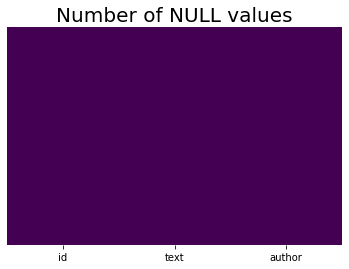

In [0]:
# Lets check if there is any NULL values

plt.title('Number of NULL values',fontdict={'fontsize':20})
sns.heatmap(df.isnull(),yticklabels = False,cbar=False,cmap='viridis')

**The dataset has 0 NULL values which makes our task easier**

Text(0, 0.5, 'Count')

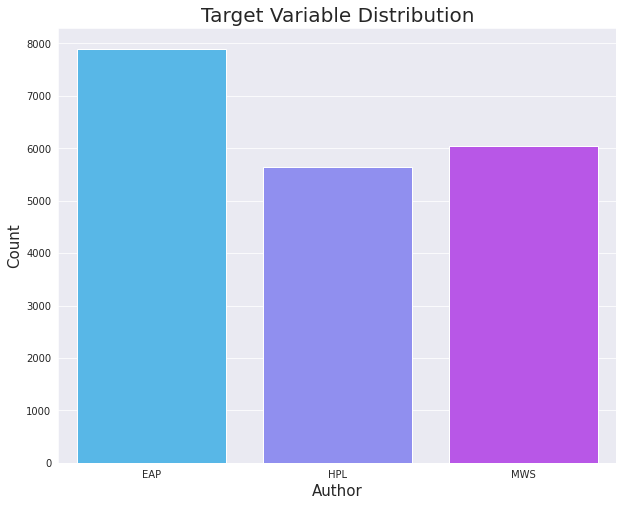

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Target Variable Distribution',fontdict={'fontsize':20})
sns.countplot(df['author'] ,palette = 'cool' ,color = 'dark' )
plt.xlabel('Author',fontdict={'fontsize':15})
plt.ylabel('Count',fontdict={'fontsize':15})


 It is clear from the above **histogram** that the dataset consists mostly of **Edgar Allan Poe** sentences.







Text(0, 0.5, 'Count in %')

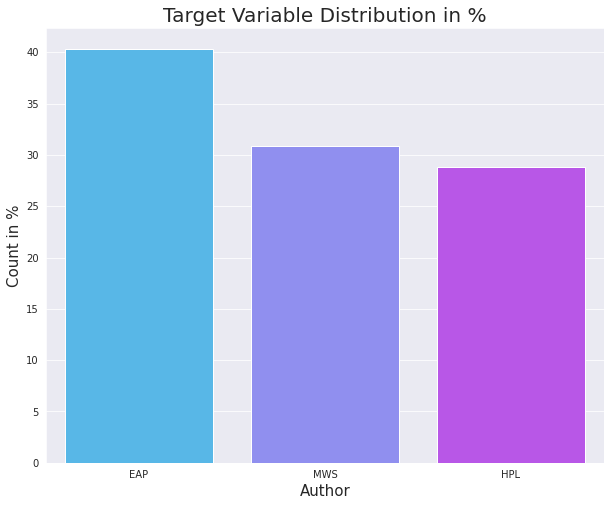

In [0]:
temp = df['author'].value_counts()
sns.set_style('darkgrid')
fig = plt.subplots(figsize=(10,8))
plt.title('Target Variable Distribution in %' ,fontdict = {'fontsize':20})
sns.barplot(x = temp.index ,y = (temp/temp.sum())*100 ,palette = 'cool' ,color = 'dark')
plt.xlabel('Author' ,fontdict = {'fontsize':15})
plt.ylabel('Count in %' ,fontdict = {'fontsize':15})


 From this **histogram** we can see that **Edgar Allan Poe** constitutes about 40% of the dataset.

### **Feature Extraction**

In [0]:
df['no: of characters'] = df['text'].apply(lambda x: len(x))
df.head()

,id,text,author,no: of characters
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


In [0]:
# Checking if there is any skew in the data

df['no: of characters'].skew()

7.350785923195449

Text(0.5, 0, 'Length')

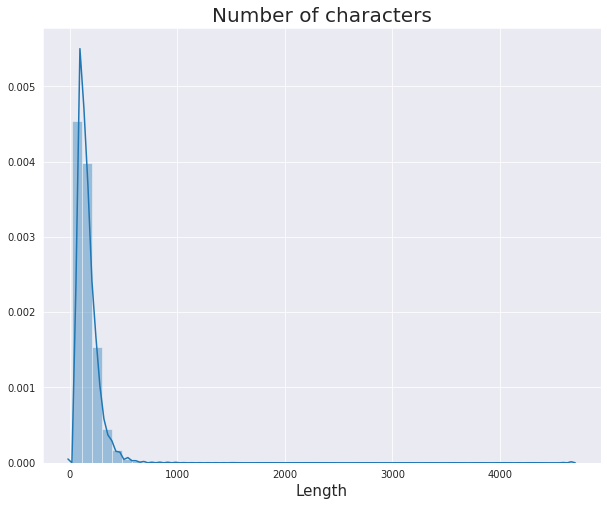

In [0]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Number of characters' ,fontdict = {'fontsize':20} )
sns.distplot(df['no: of characters'])
plt.xlabel('Length' ,fontdict = {'fontsize':15}) 





It is evident from the above **distplot** that the lenth column is **skewed** towards one side

Text(0.5, 0, 'Log(length)')

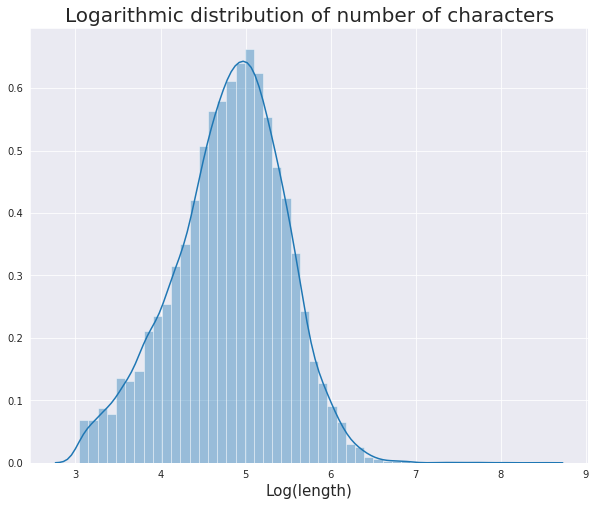

In [0]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Logarithmic distribution of number of characters' , fontdict = {'fontsize':20})
sns.distplot(np.log(df['no: of characters']))
plt.xlabel('Log(length)',fontdict={'fontsize':15})


### From the above distplot , it is clear that the distribution is not skewed and infact it is normalized!.


---








Text(0.5, 0, 'Length of words')

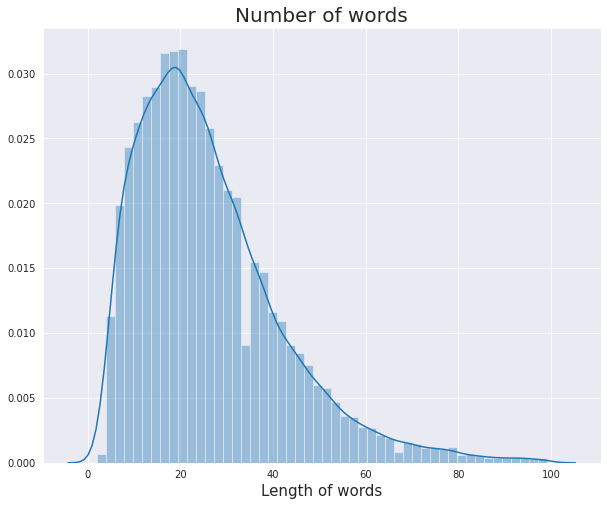

In [0]:
fig = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Number of words',fontdict={'fontsize':20})
sns.distplot(df[df['text'].str.split().map(lambda x: len(x)) < 100]['text'].str.split().map(lambda x: len(x)))
plt.xlabel('Length of words' ,fontdict={'fontsize':15})

 From the above **distplot** it is clear that most sentences in the dataset has about **20 words**. 



---







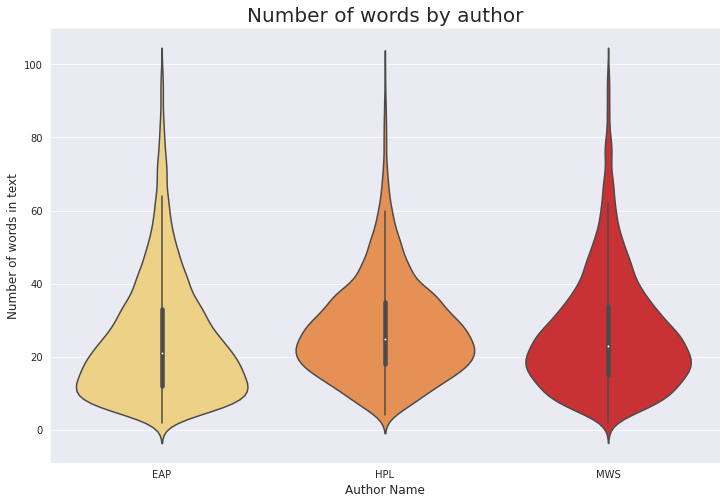

In [0]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.violinplot(x='author', y=df[df['text'].str.split().map(lambda x:len(x))<100]['text'].str.split().map(lambda x:len(x)), data=df,palette='YlOrRd')
plt.xlabel('Author Name', fontdict = {'fontsize':12})
plt.ylabel('Number of words in text', fontdict = {'fontsize':12})
plt.title("Number of words by author", fontdict = {'fontsize':20})
plt.show()

From the above **violin plot**, we can see that **H.P Lovecraft** has the most average word length, followed by **Mary Wollstonecraft** and **Edgar Allan Poe**


---



---



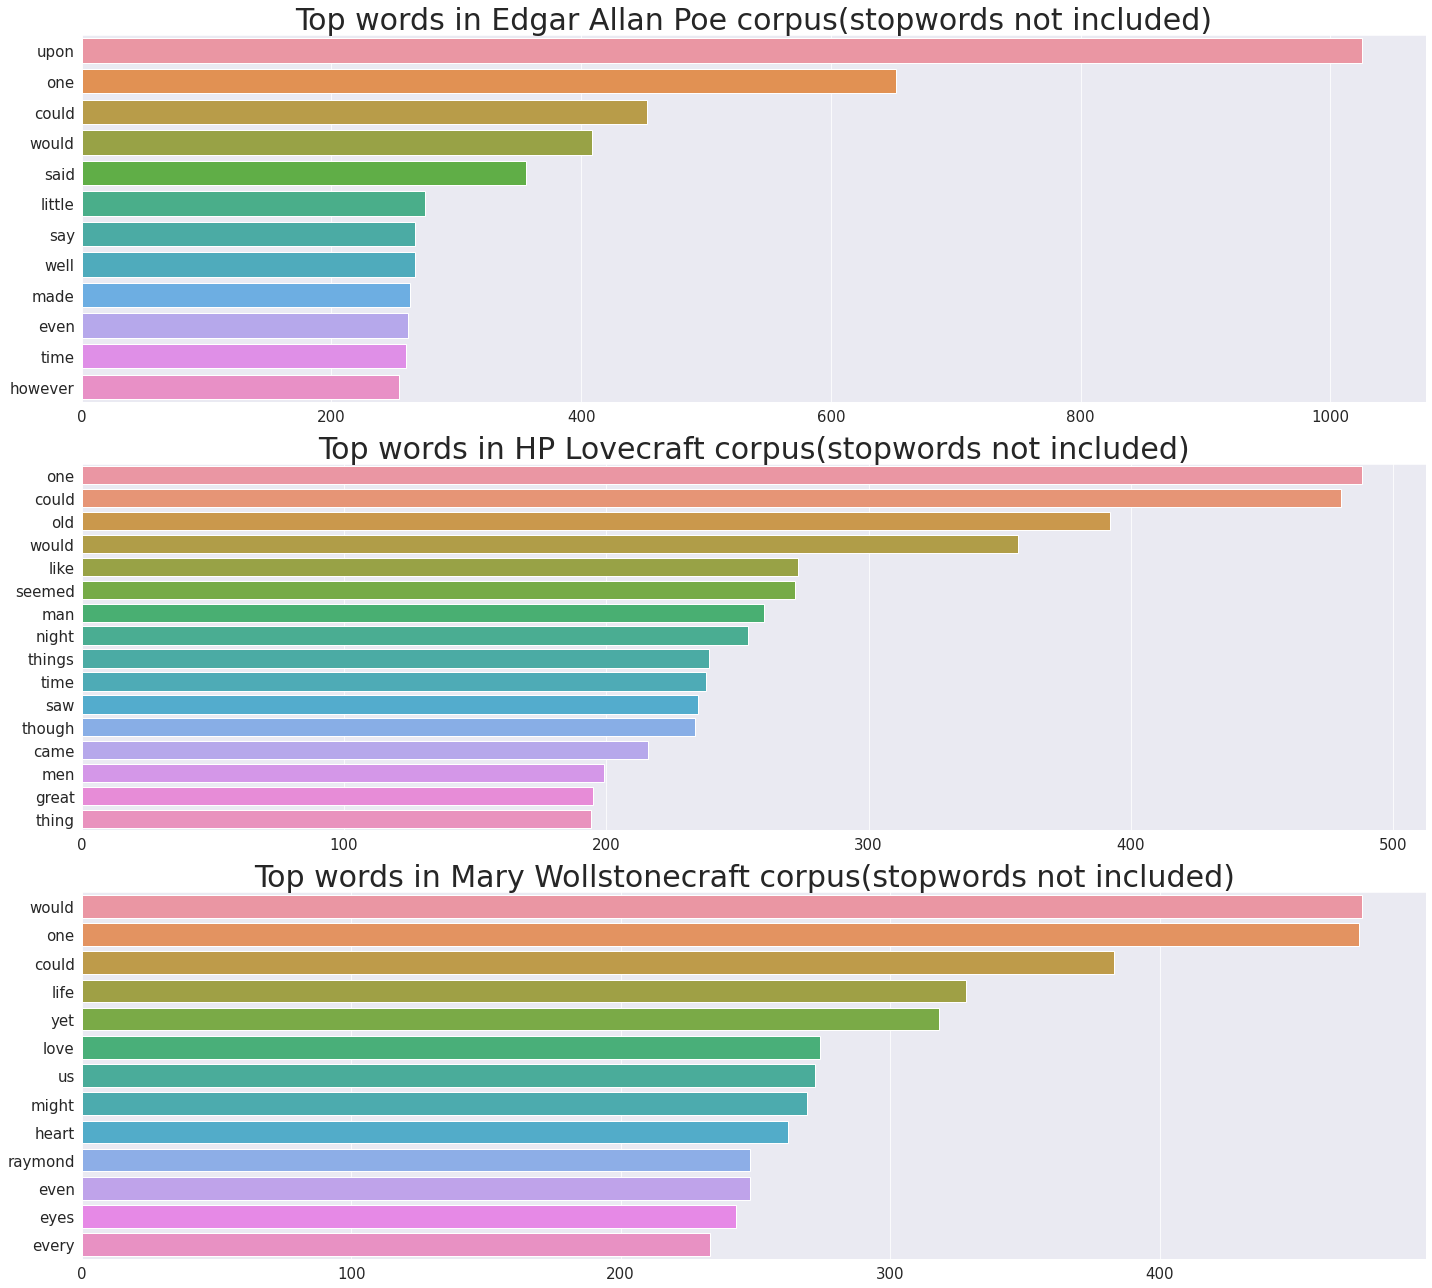

In [0]:
warnings.filterwarnings("ignore")
from collections import Counter

eap = df[df['author']=='EAP']
hpl = df[df['author']=='HPL']
mws = df[df['author']=='MWS']

def sub_clean(text):

  text = text.lower()
  text = re.sub('[^a-z\.\s]','',text)
  text = re.sub('\.',' ',text)

  return text
eap['text'] = eap['text'].apply(lambda x: sub_clean(x))
hpl['text'] = hpl['text'].apply(lambda x: sub_clean(x))
mws['text'] = mws['text'].apply(lambda x :sub_clean(x))


stop = set(stopwords.words('english'))

fig , axes = plt.subplots(3,1,figsize=(20,18))

title = ['Top words in Edgar Allan Poe corpus(stopwords not included)' , 'Top words in HP Lovecraft corpus(stopwords not included)' , 'Top words in Mary Wollstonecraft corpus(stopwords not included)  ']

for i , data in enumerate([eap,hpl,mws]):
  ax = axes[i]
  corpus=[]
  text = data['text'].str.split()
  text = text.values.tolist()
  corpus = [word for i in text for word in i ]

  counter = Counter(corpus)
  most = counter.most_common()
  x,y = [],[]
  for word,count in most[:80]:
    if word not in stop:
      x.append(word)
      y.append(count)
  
  ax.set_title(title[i] ,fontdict={'fontsize':30})
  ax.tick_params(axis='both',labelsize=15)
  sns.barplot(x=y,y=x,ax=ax)

plt.tight_layout()
plt.show()
plt.close()

# **bi-grams and tri-grams**

 Ngrams are simply continuous sequences of n words. If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.



In [0]:

def n_gram_words(corpus,n):

    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    freq_dist = [(word,sum_words[0,idx]) for word , idx in vec.vocabulary_.items()]
    freq_dist = sorted(freq_dist , key = lambda x:x[1], reverse=True)[:15]
    
    return freq_dist
  

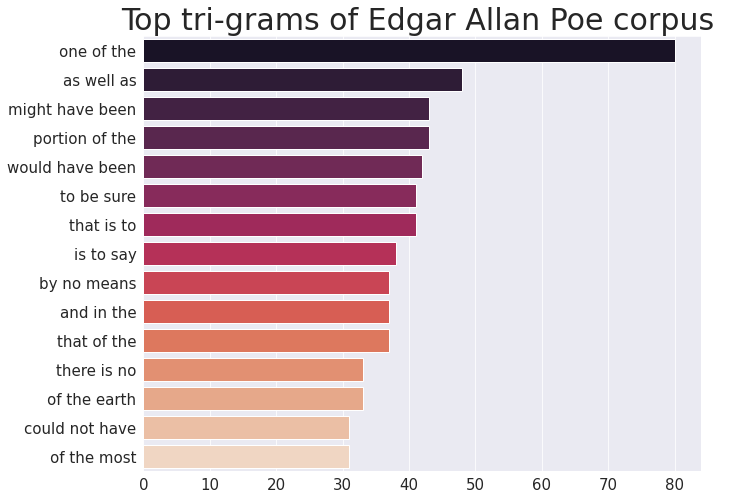

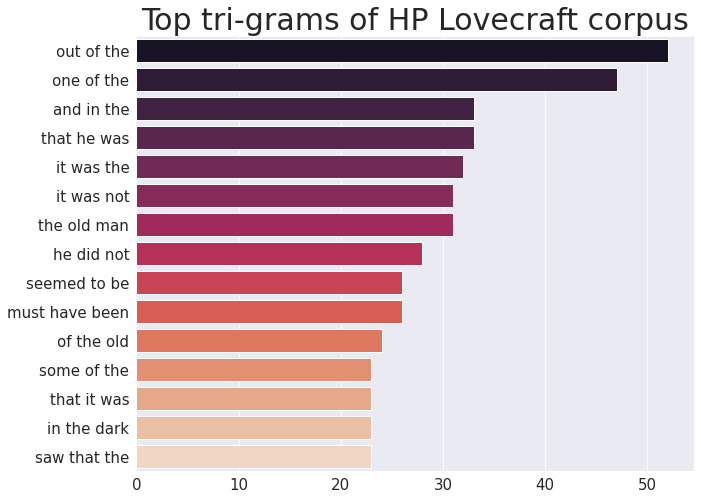

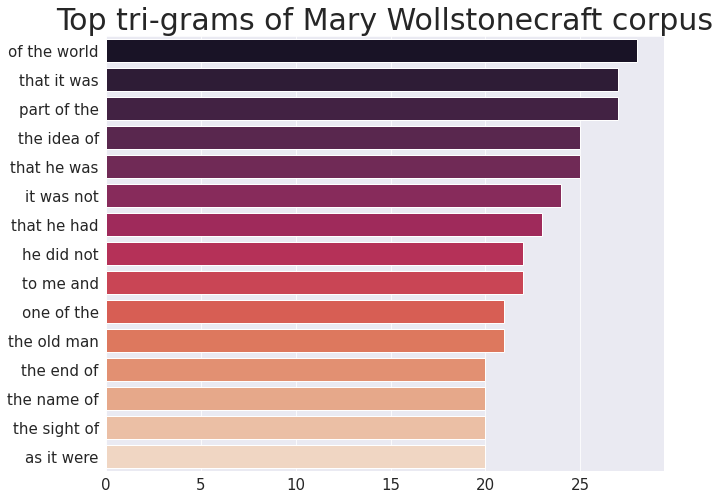

In [0]:
top_bigrams_eap = n_gram_words(eap['text'],3)
fig = plt.subplots(figsize=(10,8))
x,y = map(list,zip(*top_bigrams_eap))
plt.title('Top tri-grams of Edgar Allan Poe corpus ', fontdict={'fontsize':30})
sns.barplot(x=y,y=x,palette='rocket')
plt.tick_params(axis='both',labelsize=15)
plt.show()

top_bigrams_hpl = n_gram_words(hpl['text'],3)
fig = plt.subplots(figsize=(10,8))
x,y =map(list,zip(*top_bigrams_hpl))
plt.title('Top tri-grams of HP Lovecraft corpus' , fontdict={'fontsize':30})
sns.barplot(x=y,y=x,palette = 'rocket')
plt.tick_params(axis='both',labelsize=15)
plt.show()

top_bigrams_mws = n_gram_words(mws['text'],3)
fig = plt.subplots(figsize=(10,8))
x,y =map(list,zip(*top_bigrams_mws))
plt.title('Top tri-grams of Mary Wollstonecraft corpus' , fontdict={'fontsize':30})
sns.barplot(x=y,y=x,palette = 'rocket')
plt.tick_params(axis='both',labelsize=15)
plt.show()


### It is clear from the above graph that the dataset consists of many **stopwords**.


---




# **Cleaning the data**



In [0]:
def clean(text):
  
  text = re.sub('[^A-Za-z\.\s]','',text)
  text = re.sub('\.',' ',text)
  text = text.lower().split()
  stop = set(stopwords.words('english'))
  text = [word for word in text if word not in stop]
  text = ' '.join(text)
  
  return text

eap['text'] = eap['text'].apply(lambda x : clean(x))
hpl['text'] = hpl['text'].apply(lambda x : clean(x))
mws['text'] = mws['text'].apply(lambda x : clean(x))




In [0]:
eap.head()

,id,text,author,no: of characters
0,id26305,process however afforded means ascertaining di...,EAP,231
2,id11008,left hand gold snuff box capered hill cutting ...,EAP,200
6,id09674,astronomer perhaps point took refuge suggestio...,EAP,128
7,id13515,surcingle hung ribands body,EAP,43
8,id19322,knew could say stereotomy without brought thin...,EAP,488


### Using **WordNetLemmatizer** to remove inflectional endings  and to return the base or dictionary form of a word.

In [0]:
def preprocess(df):
  
  corpus = []
  lemmatizer = WordNetLemmatizer()
  for news in df['text']:
    word = [w for w in word_tokenize(news)]
    word = [lemmatizer.lemmatize(w) for w in word if len(w)>2]
    corpus.append(word)

  return corpus

# **Topic Modeling using pyLDAvis**

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.
The latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

In [0]:
corpus_eap = preprocess(eap)
corpus_hpl = preprocess(hpl)
corpus_mws = preprocess(mws)
authors = ['Edgar Allan Poe','H.P Lovecraft','Mary Wollstonecraft']

for i , data in enumerate([corpus_eap,corpus_hpl,corpus_mws]):
  dic = gensim.corpora.Dictionary(data)
  bow_corpus = [dic.doc2bow(doc) for doc in data]
  lda_model = gensim.models.LdaMulticore(bow_corpus , num_topics=10 , id2word=dic, passes = 10, workers=2)
  print('The topics of {} are'.format(authors[i]))
  display(lda_model.show_topics())
  print('\n')
  print('\n')


The topics of Edgar Allan Poe are


[(0,
  '0.009*"upon" + 0.005*"time" + 0.004*"thing" + 0.004*"would" + 0.004*"day" + 0.004*"even" + 0.003*"man" + 0.003*"hand" + 0.003*"thus" + 0.003*"may"'),
 (1,
  '0.010*"one" + 0.009*"upon" + 0.005*"many" + 0.005*"day" + 0.004*"thought" + 0.003*"year" + 0.003*"found" + 0.003*"long" + 0.003*"well" + 0.003*"arm"'),
 (2,
  '0.014*"upon" + 0.008*"could" + 0.005*"one" + 0.005*"found" + 0.004*"voice" + 0.004*"well" + 0.003*"made" + 0.003*"last" + 0.003*"said" + 0.003*"night"'),
 (3,
  '0.008*"would" + 0.007*"upon" + 0.007*"one" + 0.006*"said" + 0.005*"much" + 0.005*"thought" + 0.004*"matter" + 0.004*"first" + 0.004*"however" + 0.004*"well"'),
 (4,
  '0.004*"earth" + 0.004*"yet" + 0.004*"much" + 0.004*"time" + 0.003*"thing" + 0.003*"let" + 0.003*"might" + 0.003*"little" + 0.003*"one" + 0.003*"upon"'),
 (5,
  '0.009*"one" + 0.008*"upon" + 0.006*"made" + 0.005*"could" + 0.004*"foot" + 0.004*"said" + 0.004*"say" + 0.004*"great" + 0.003*"still" + 0.003*"point"'),
 (6,
  '0.007*"said" + 0.007*"





The topics of H.P Lovecraft are


[(0,
  '0.007*"thing" + 0.006*"old" + 0.006*"house" + 0.006*"seemed" + 0.005*"day" + 0.005*"one" + 0.005*"would" + 0.004*"upon" + 0.004*"could" + 0.004*"dream"'),
 (1,
  '0.005*"found" + 0.004*"thing" + 0.004*"old" + 0.004*"day" + 0.004*"though" + 0.004*"never" + 0.004*"year" + 0.004*"near" + 0.004*"seemed" + 0.003*"west"'),
 (2,
  '0.007*"like" + 0.006*"one" + 0.006*"could" + 0.005*"upon" + 0.004*"old" + 0.004*"place" + 0.003*"seemed" + 0.003*"thing" + 0.003*"head" + 0.003*"time"'),
 (3,
  '0.008*"thing" + 0.006*"time" + 0.006*"year" + 0.005*"great" + 0.004*"one" + 0.004*"seemed" + 0.004*"old" + 0.004*"even" + 0.004*"man" + 0.004*"though"'),
 (4,
  '0.006*"thing" + 0.005*"door" + 0.005*"like" + 0.004*"house" + 0.004*"window" + 0.004*"sound" + 0.004*"dream" + 0.003*"men" + 0.003*"street" + 0.003*"would"'),
 (5,
  '0.010*"could" + 0.009*"would" + 0.009*"one" + 0.006*"never" + 0.005*"old" + 0.005*"thing" + 0.005*"night" + 0.004*"came" + 0.004*"say" + 0.004*"said"'),
 (6,
  '0.007*"like" 





The topics of Mary Wollstonecraft are


[(0,
  '0.013*"could" + 0.008*"eye" + 0.006*"must" + 0.005*"yet" + 0.005*"love" + 0.005*"even" + 0.004*"feeling" + 0.004*"upon" + 0.004*"among" + 0.004*"life"'),
 (1,
  '0.008*"life" + 0.006*"would" + 0.006*"day" + 0.005*"could" + 0.005*"word" + 0.005*"not" + 0.005*"can" + 0.005*"love" + 0.005*"yet" + 0.005*"world"'),
 (2,
  '0.015*"would" + 0.007*"one" + 0.006*"never" + 0.006*"eye" + 0.005*"day" + 0.005*"shall" + 0.005*"see" + 0.004*"word" + 0.004*"life" + 0.004*"could"'),
 (3,
  '0.007*"father" + 0.007*"yet" + 0.007*"year" + 0.006*"one" + 0.005*"death" + 0.005*"country" + 0.005*"thy" + 0.004*"good" + 0.004*"might" + 0.004*"child"'),
 (4,
  '0.007*"raymond" + 0.007*"would" + 0.006*"perdita" + 0.006*"thus" + 0.005*"said" + 0.005*"better" + 0.005*"every" + 0.005*"time" + 0.005*"man" + 0.004*"upon"'),
 (5,
  '0.007*"one" + 0.007*"might" + 0.006*"would" + 0.005*"man" + 0.005*"love" + 0.004*"first" + 0.004*"creature" + 0.004*"nature" + 0.004*"happiness" + 0.003*"even"'),
 (6,
  '0.007*"hea

### **Topic modeling brings about the smallest insights in the data , for  example you can see that in the corpus of Mary Wollstonecraft , she talks about death , misery and love.** 
However in this dataset , the training examples are just 2-3 sentences of a whole book. Therefore it is hard to gain minute insights through topic modeling.If we printed the coherence score for the topics we can see that it is very low . Nevertheless , topic modeling is a good process to understand the data very well.


---



---



# **WordCloud**



In [0]:
from wordcloud import WordCloud,STOPWORDS


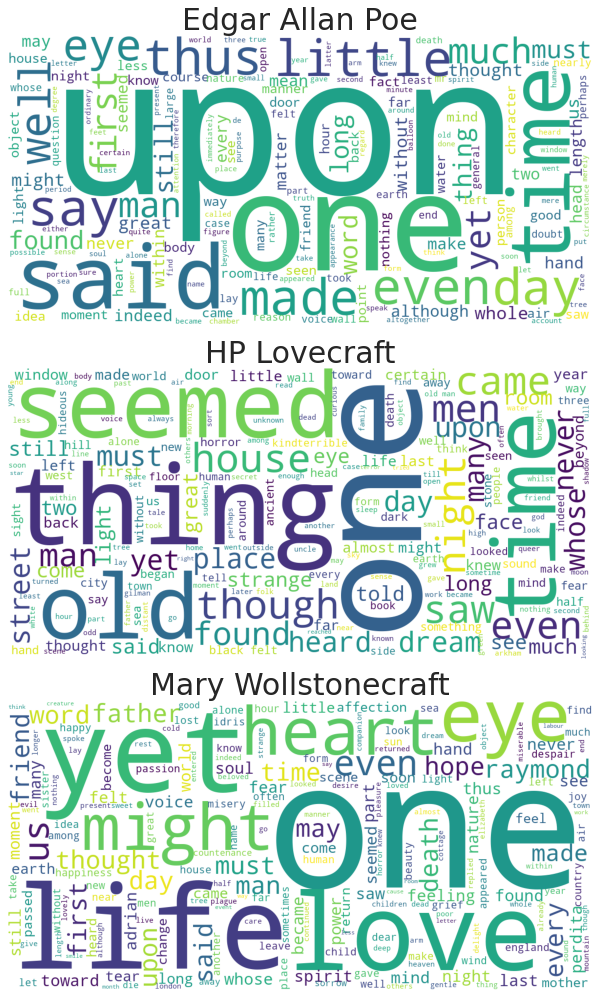

In [0]:
fig , axes = plt.subplots(3,1,figsize=(16,14))
eap_wc = eap['text'].values
hpl_wc = hpl['text'].values
mws_wc = mws['text'].values
title_wc = ['Edgar Allan Poe' , 'HP Lovecraft' , 'Mary Wollstonecraft']
for i , data in enumerate([eap_wc , hpl_wc , mws_wc]):
  wc = WordCloud(stopwords=STOPWORDS , max_words=200 , background_color='white' , max_font_size=None , scale=3)
  wc = wc.generate(" ".join(data))
  axes[i].set_title(title_wc[i] ,fontdict={'fontsize':30})
  axes[i].imshow(X = wc)
  axes[i].axis('off')
  
plt.tight_layout()
plt.show()
plt.close()

# **Sentiment Analysis**



In [0]:
from textblob import TextBlob

df['polarity_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,id,text,author,no: of characters,polarity_score
0,id26305,"This process, however, afforded me no means of...",EAP,231,0.625000
1,id17569,It never once occurred to me that the fumbling...,HPL,71,-0.500000
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0.107407
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,0.500000
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,0.200000


Text(0.5, 0, 'Polarity Score')

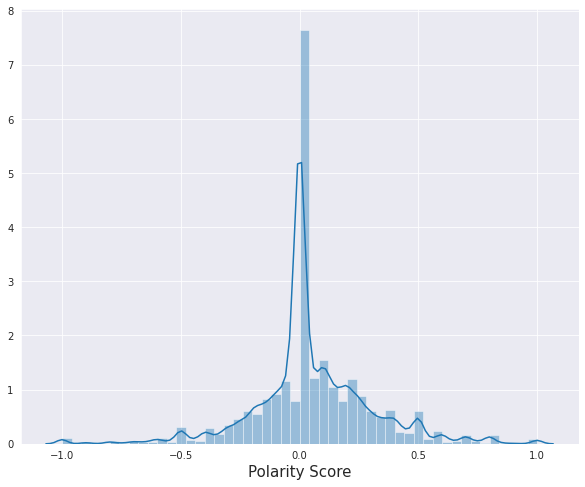

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.distplot(df['polarity_score'])
plt.xlabel('Polarity Score',fontdict = {'fontsize':15})


 It is clear from the above **distplot** that the polarity score ranges from **0.0 to 0.20** in most of the sentences.





In [0]:
pd.set_option('display.max_colwidth',75)

print(df[df['polarity_score']==min(df['polarity_score'])]['text'].iloc[0:10])

286     Haow'd ye like to hear what comes from that awful reef every May Eve an...
414     An' the smell was awful, like what it is araound Wizard Whateley's ol' ...
535               God raises my weakness and gives me courage to endure the worst.
623     I looked towards its completion with a tremulous and eager hope, which ...
964     For a moment my soul was elevated from its debasing and miserable fears...
1019    Cable advices from Dunedin report that the Alert was well known there a...
2267    Methought its spirit whispered evil counsel, soothing me to traitorous ...
2310    If she died, where could there be found on record a murderer, whose cru...
2676    No one cared to remain there amidst the stench and tarry stickiness, bu...
2832    On his initiative we combed the countryside for information regarding t...
Name: text, dtype: object


Text(0, 0.5, 'Polarity Score')

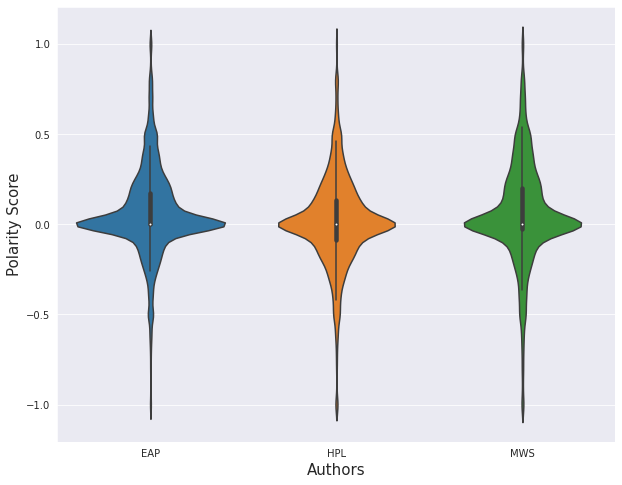

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.violinplot(x='author',y='polarity_score',data=df)
plt.xlabel('Authors',fontdict={'fontsize':15})
plt.ylabel('Polarity Score',fontdict={'fontsize':15})


It's pretty obvious from the above **violin plot** that **Edgar Allan Poe** datasets consists of more **neutral** sentences than the other authors.

Text(0, 0.5, 'Polarity Score')

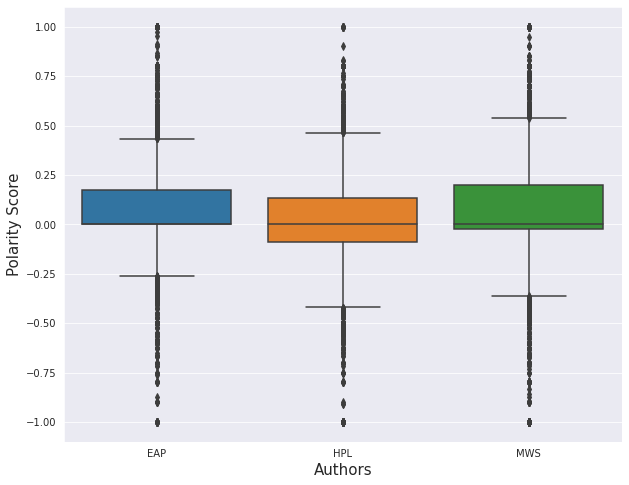

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.boxplot(x='author',y='polarity_score',data=df)
plt.xlabel('Authors',fontdict={'fontsize':15})
plt.ylabel('Polarity Score',fontdict={'fontsize':15})

The **median** of all the 3 authors is **equal to 0 or close to it.** The **boxplot** also hints that **H.P Lovecraft** has more sentences with **polarity score less than 0** than the other authors.


---







In [0]:
df['polarity'] = df['polarity_score'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x>0 else 'Negative') )

In [0]:
df.head()

,id,text,author,no: of characters,polarity_score,polarity
0,id26305,"This process, however, afforded me no means of...",EAP,231,0.625000,Positive
1,id17569,It never once occurred to me that the fumbling...,HPL,71,-0.500000,Negative
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0.107407,Positive
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,0.500000,Positive
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,0.200000,Positive


Text(0, 0.5, 'Count')

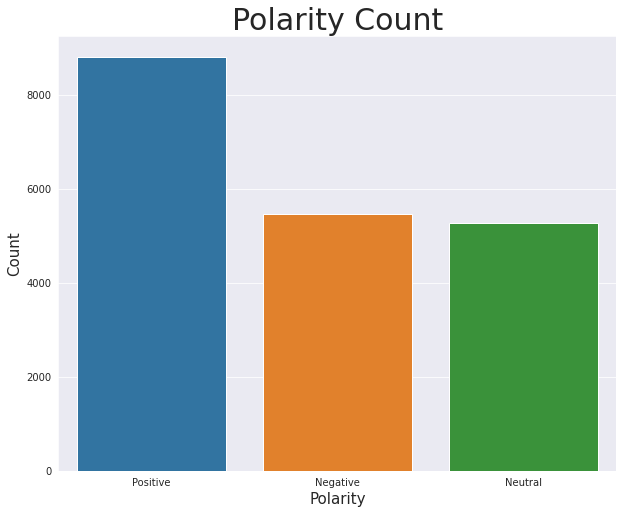

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.countplot(df['polarity'])
plt.title('Polarity Count',fontdict={'fontsize':30})
plt.xlabel('Polarity',fontdict={'fontsize':15})
plt.ylabel('Count',fontdict={'fontsize':15})


From the above **histogram** it is evident that the **positive sentiment**  seems to outnumber the rest of the sentiments.


---







Text(0, 0.5, 'Count')

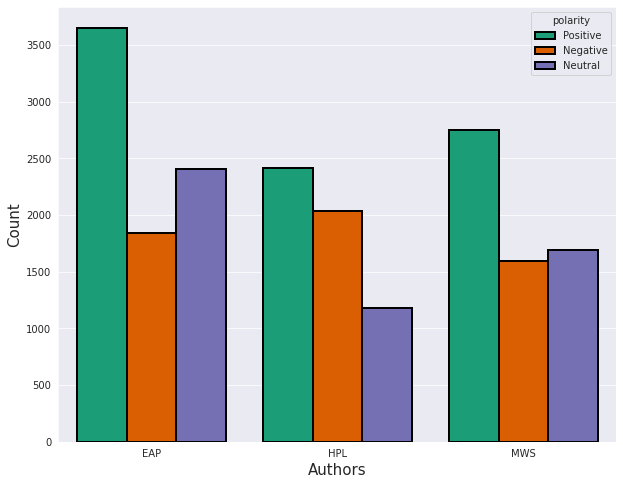

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.countplot(df['author'],hue=df['polarity'],saturation = 1,edgecolor=(0,0,0),palette = 'Dark2',linewidth = 2)
plt.xlabel('Authors',fontdict={'fontsize':15})
plt.ylabel('Count',fontdict = {'fontsize':15})


 It looks like ***Edgar Allan Poe has more Positive and Neutral sentences*** than the other authors(it could be due to more number of samples) and ***H.P Lovecraft has more negative sentences*** than the others as given by the **boxplot**!


---






# **Named Entity Recognition**




In [0]:
!python3 -m spacy download en_core_web_sm


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [0]:
def ner(text):
  doc = nlp(text)
  return [X.label_ for X in doc.ents]

rec = df['text'].apply(lambda x: ner(x))


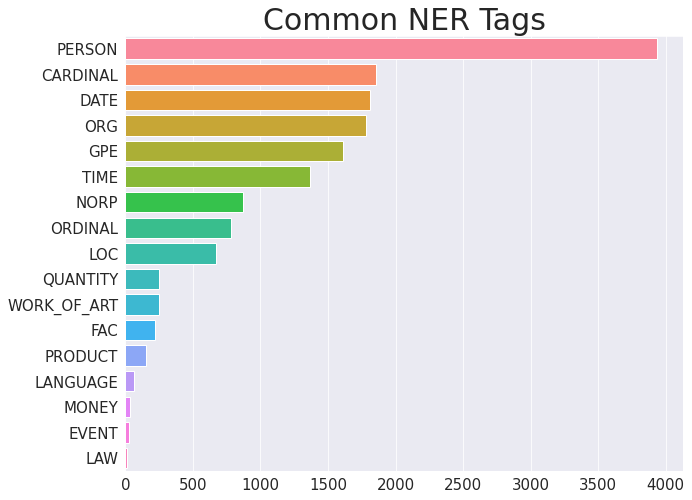

In [0]:
ner_tags = [x for sub in rec for x in sub]
counter = Counter(ner_tags)
count = counter.most_common()
x,y = map(list,zip(*count))

plt.subplots(figsize=(10,8))
plt.title('Common NER Tags',fontdict = {'fontsize':30})
sns.barplot(x=y,y=x,saturation=1)
plt.tick_params(axis='both',labelsize=15)

It is clear that the **PERSON** tag is the most common followed by **CARDINAL and DATE.**



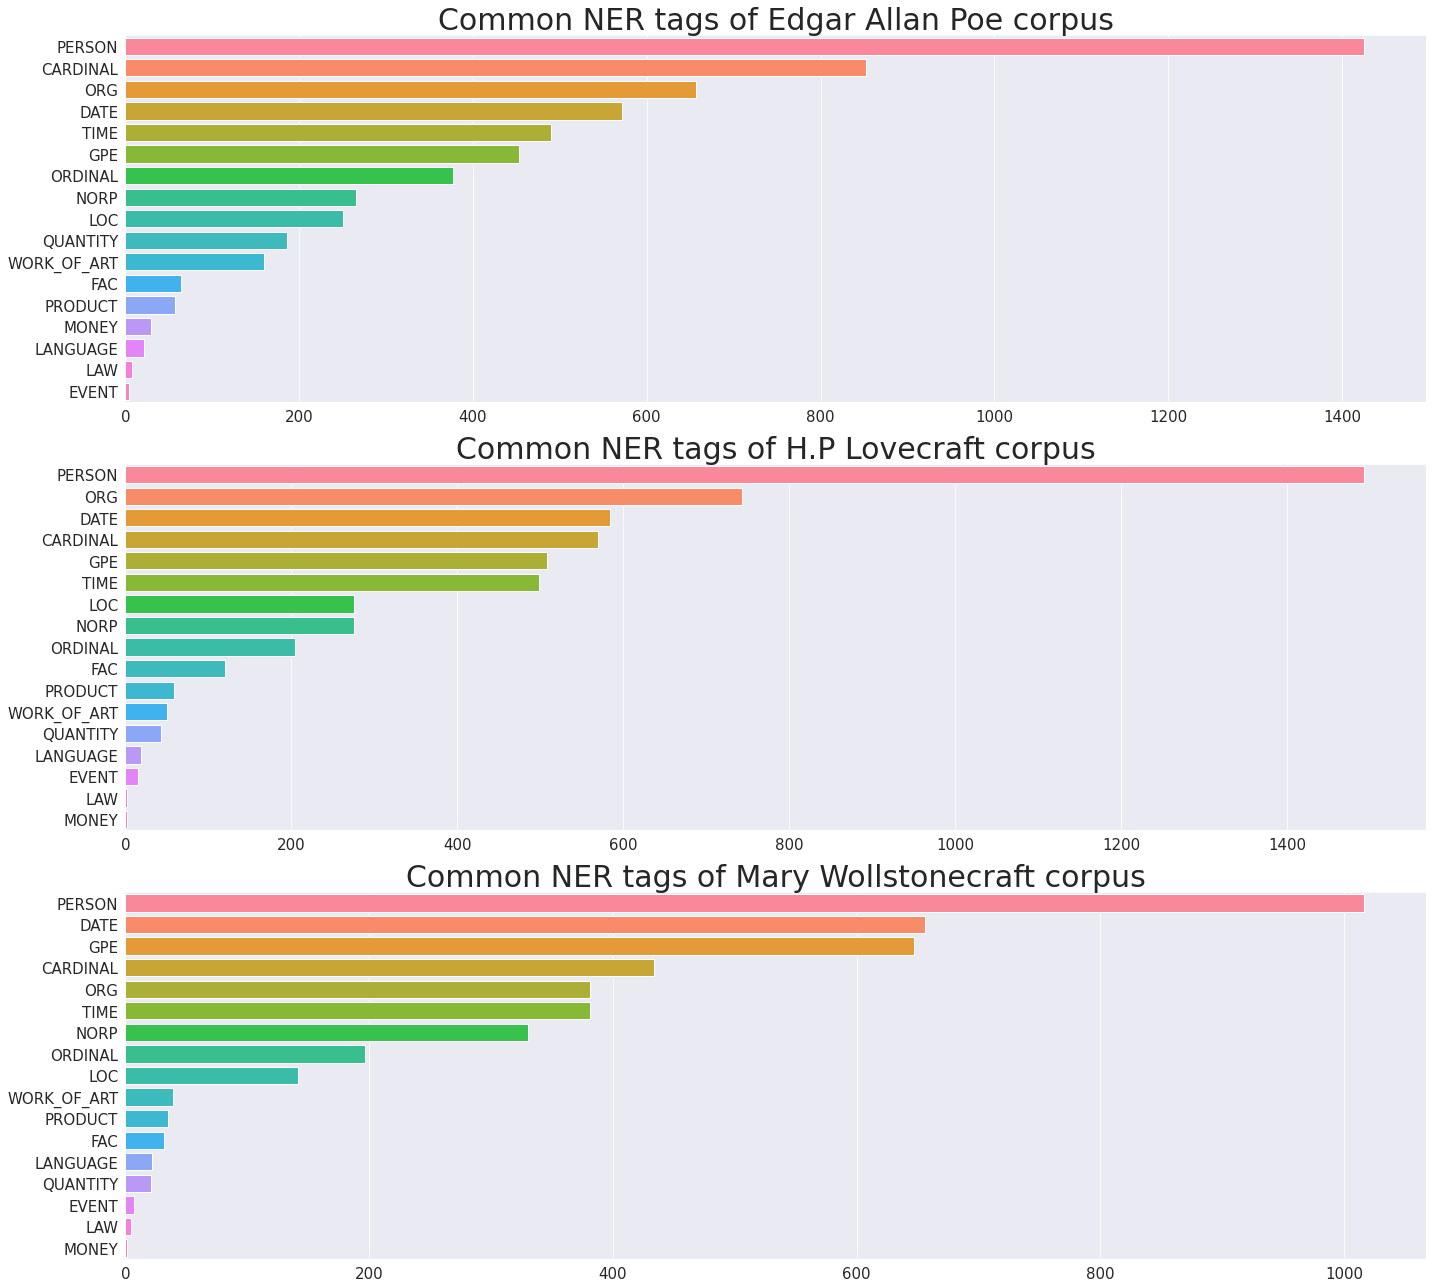

In [0]:
eap = df[df['author']=='EAP']
hpl = df[df['author']=='HPL']
mws = df[df['author']=='MWS']
fig,axes = plt.subplots(3,1,figsize=(20,18))
title_ner = ['Common NER tags of Edgar Allan Poe corpus' , 'Common NER tags of H.P Lovecraft corpus' , 'Common NER tags of Mary Wollstonecraft corpus']

for i,data in enumerate([eap,hpl,mws]):

  rec_author = data['text'].apply(lambda x: ner(x))
  ner_tags_author = [x for sub in rec_author for x in sub]
  counter = Counter(ner_tags_author)
  most = counter.most_common()
  x,y = map(list,zip(*most))
  sns.barplot(x=y,y=x,ax=axes[i],saturation=1)
  axes[i].set_title(title_ner[i],fontdict = {'fontsize':30})
  axes[i].tick_params(axis='both',labelsize = 15)

plt.tight_layout()
plt.show()
plt.close()


# **Text Complexity**

It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. I feel this is an important feature to visualize as the 3 of the label features are authors and it's good to understand if we can understand their work or not.

### **Although there are many readability score formula available , I will be using the Flesch Reading Ease index.**
FRE = 206.835 − 1.015 * (total words/total sentences) − 84.6 * (total      syllables/ total words)

Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:- 0-30 College- 50-60 High school- 60+ Fourth grade

In [0]:
from textstat import flesch_reading_ease

df['readability'] = df['text'].apply(lambda x : flesch_reading_ease(x))
df.head()

,id,text,author,no: of characters,polarity_score,polarity,readability
0,id26305,"This process, however, afforded me no means of...",EAP,231,0.625000,Positive,46.78
1,id17569,It never once occurred to me that the fumbling...,HPL,71,-0.500000,Negative,82.65
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0.107407,Positive,51.86
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,0.500000,Positive,53.89
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,0.200000,Positive,44.07


In [0]:
display(df[df['readability']==min(df['readability'])]['text'].iloc[0])

'Diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her Without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before I attempt to repeat her words I will describe the chief of these whom she appeared to wish principally to impress One was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in ringlets on her shoulders her hazle eyes were shaded by heavy lids and her mouth the lips apart seemed to breathe sensibility But she appeared thoughtful unhappy her cheek was pale she seemed as if accustomed to suffer and as if the lessons she now heard were the only words of wisdom to which she had ever listened The youth beside her had a far different aspect his form was emaciated nearly to a shadow his features were handsome but thin worn his eyes glistened as if animating the visage of deca

## As we can see this sentence was a slight hard to read and the author was Mary Wollstonecraft. Let's plot the graph and find out more information

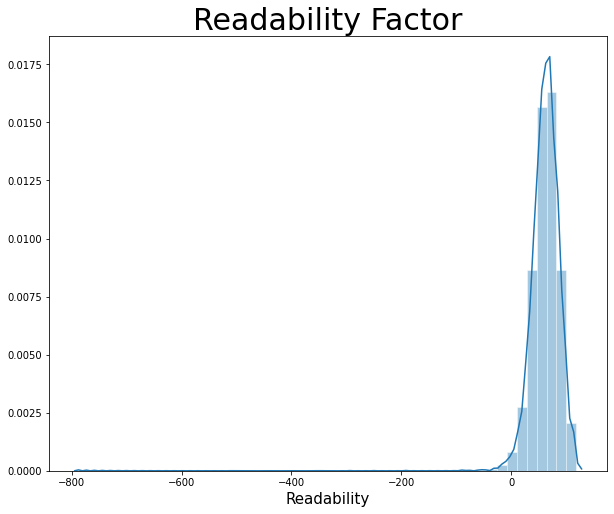

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Readability Factor',fontdict={'fontsize':30})
sns.distplot(df['readability'])
plt.xlabel('Readability',fontdict={'fontsize':15})
plt.tick_params(axis='both',labelsize = 10)

It is evident from the above **distplot** that most of the readability factor is **greater than 0**. Although  some **reached as low as -800.** This makes sense as these authors are 19th century authors and we know the English language of that time is hard to interpret and understand

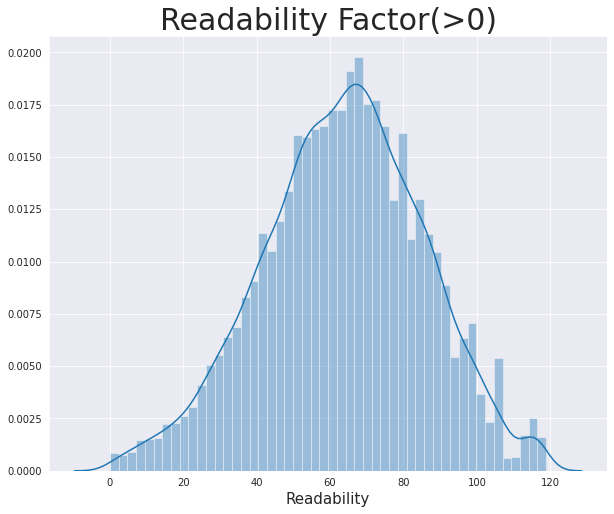

In [0]:
plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
plt.title('Readability Factor(>0)',fontdict={'fontsize':30})
sns.distplot(df[df['readability']>0]['readability'])
plt.xlabel('Readability',fontdict={'fontsize':15})
plt.tick_params(axis='both',labelsize = 10)

 Even though they were old authors ,it is evident from the above **distplot** that  most of their works have a readability work **greater than 60**, which means an average 4th grade student can understand. But there are a good number of sentences with readability less than 60.

Text(0, 0.5, 'Readability Factor')

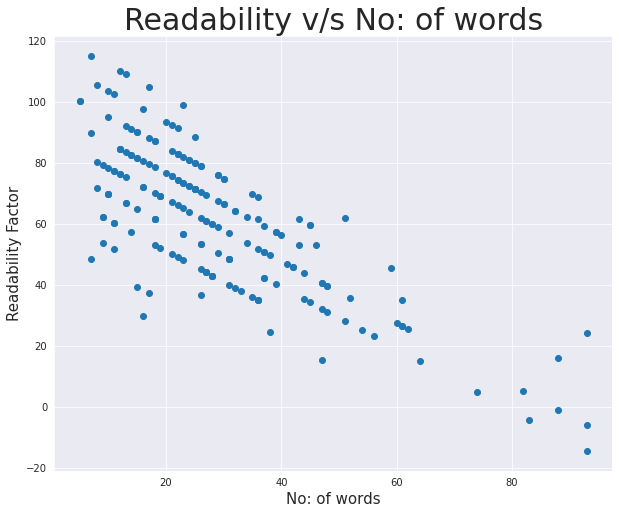

In [0]:
plt.subplots(figsize=(10,8))
plt.scatter(df[df['text'].str.split().map(lambda x:len(x))<100]['text'][:200].str.split().map(lambda x:len(x)),df[df['text'].str.split().map(lambda x:len(x))<100]['readability'][:200])
plt.title('Readability v/s No: of words',fontdict ={'fontsize':30})
plt.xlabel('No: of words',fontdict={'fontsize':15})
plt.ylabel('Readability Factor',fontdict={'fontsize':15})

**We can see that there is a linear connection between Readability Factor and no: of words,  the Readability factor decreases as the number of words increases**


---







# **Conclusion**

Through the use of exploratory data analysis I got to see minute insights into the data which will greatly help me in model building. I also noticed some outliers in the data. Some of the insights were :


*   Mary Wollstonecraft seems to use the words love, death , etc in
    her works
  
*   Most of the sentences had positive sentiment sentences, and 
    H.P Lovecraft seemed to use more negative sentiment sentences than anybody else, and this is true , H.P Lovecraft wrote more books on horror and science fiction .


*   Most of the sentences was readable by an average 4th grader , but some sentences had a readability score of -800 , which made sense because these authors were 19th century authors and they probably used early modern english.
*  The readability scored decreases as the number of words increases.



